### 1. [20 points. 1.5 hours.] Using the “Eigenfaces.ipynb” program shown in class (Lecture 6 folder), find the number of dimensions at which the variance preserved first hits the 50%, 60%, 70%, 80%, 90%, and 95% mark. Then for each graph the macro average F-1 score for classification using SVM.

In [1]:
import tarfile
from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC

##### import dataset

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# Instead of providing 2D data, X has data already in the form of a vector that is required in this approach.
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Number of samples: %d" % n_samples)
print("Number of features: %d" % n_features)
print("name of classes: ", target_names)

Number of samples: 1288
Number of features: 1850
name of classes:  ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


##### split dataset into training and testing sets

In [3]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

##### PCA

In [4]:
n_components = 150
print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
# create the PCA
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.336s


In [5]:
eigenfaces = pca.components_.reshape((n_components, h, w))
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
# transform the data into the principle component representation
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Projecting the input data on the eigenfaces orthonormal basis
done in 0.014s


##### SVM

In [6]:
print("Fitting the classifier to the training set")
#try many hyperparameter combinations of C, gamma 
t0 = time()
param_grids = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma':  [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
}
# create the classifier
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grids)
# fit the data
clf = clf.fit(X_train_pca, y_train)

print('done in %0.3fs' % (time() - t0))
print('Best estimator found in grid search:')
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 12.617s
Best estimator found in grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


##### Quantitative evaluation of the model quality on the test set

In [7]:
print("Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print('done in %0.3fs' % (time() - t0))

Predicting the people names on the testing set
done in 0.038s


In [8]:
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.54      0.64        13
     Colin Powell       0.83      0.87      0.85        60
  Donald Rumsfeld       0.95      0.67      0.78        27
    George W Bush       0.84      0.98      0.90       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.60      0.75        15
       Tony Blair       0.93      0.78      0.85        36

         accuracy                           0.86       322
        macro avg       0.90      0.75      0.80       322
     weighted avg       0.87      0.86      0.86       322

[[  7   1   0   5   0   0   0]
 [  2  52   0   6   0   0   0]
 [  0   2  18   7   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   3  20   0   1]
 [  0   3   0   2   0   9   1]
 [  0   1   1   5   1   0  28]]


##### Qualitative evaluation of the predictions using matplotlib

In [9]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

##### Plot the result of the prediction on a portion of the test set

In [10]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

In [11]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

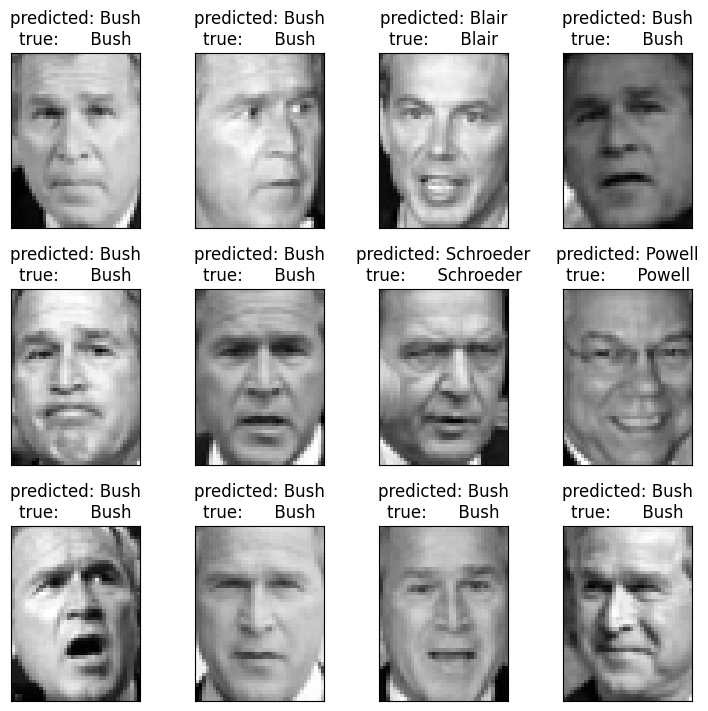

In [12]:
plot_gallery(X_test, prediction_titles, h, w)

##### Plot the gallery of the most significative eigenfaces

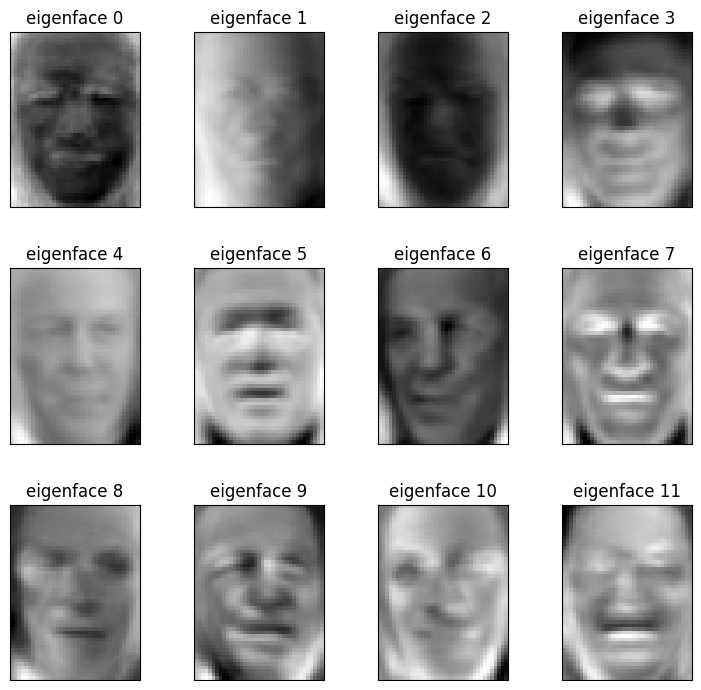

In [13]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()

##### How much of the variance is explained by the first principal component? The second?

In [14]:
pca.explained_variance_ratio_[0]

0.2086041

In [15]:
pca.explained_variance_ratio_[1]

0.14046928

In [16]:
print(pca.explained_variance_ratio_)

[0.2086041  0.14046928 0.06725664 0.05641383 0.04898051 0.02742927
 0.02394793 0.02116303 0.01901791 0.01804605 0.0156836  0.01506859
 0.01184229 0.01031152 0.01028552 0.00943705 0.00863998 0.00817821
 0.00801047 0.0072037  0.00673143 0.00627224 0.00623003 0.00545138
 0.00516479 0.00510714 0.00496873 0.00473863 0.00432875 0.00415551
 0.00389128 0.00385915 0.00358175 0.00346088 0.0034087  0.00328849
 0.00317762 0.00302014 0.00292298 0.00286995 0.00276695 0.00268668
 0.00261173 0.0026045  0.0024585  0.0024368  0.0024086  0.0022402
 0.00218233 0.00213889 0.00213492 0.00207718 0.00206597 0.00203009
 0.00198741 0.0018889  0.00187225 0.00185406 0.00180089 0.00178264
 0.00171047 0.00166128 0.00162434 0.00159352 0.00156956 0.00152409
 0.0014867  0.00147825 0.00146333 0.00145006 0.00140727 0.00139371
 0.00137373 0.0013337  0.00131192 0.00129502 0.00126716 0.00122874
 0.00121468 0.00121076 0.00119407 0.00118905 0.00116006 0.00115379
 0.00113876 0.00111801 0.0010868  0.00107952 0.00105465 0.00103

In [17]:
#sum up lambda's
accum = pca.explained_variance_ratio_
sum = 0.0
for i in range(pca.explained_variance_ratio_.shape[0]):
  accum[i] = sum + pca.explained_variance_ratio_[i]
  sum = accum[i]
print(accum)

[0.2086041  0.34907338 0.41633004 0.47274387 0.5217244  0.5491537
 0.57310164 0.5942647  0.6132826  0.6313287  0.6470123  0.6620809
 0.6739232  0.68423474 0.69452024 0.70395726 0.71259725 0.7207755
 0.72878593 0.73598963 0.7427211  0.74899334 0.7552234  0.7606748
 0.7658396  0.77094674 0.77591544 0.7806541  0.7849828  0.7891383
 0.7930296  0.79688877 0.80047053 0.8039314  0.8073401  0.8106286
 0.81380624 0.8168264  0.81974936 0.8226193  0.8253863  0.82807297
 0.8306847  0.8332892  0.8357477  0.83818454 0.84059316 0.84283334
 0.84501565 0.84715456 0.8492895  0.85136664 0.8534326  0.8554627
 0.85745007 0.85933894 0.8612112  0.86306524 0.86486614 0.8666488
 0.86835927 0.87002057 0.8716449  0.87323844 0.874808   0.8763321
 0.8778188  0.8792971  0.88076043 0.8822105  0.88361776 0.8850115
 0.8863852  0.8877189  0.8890308  0.89032584 0.891593   0.8928217
 0.8940364  0.89524716 0.8964412  0.8976303  0.89879036 0.8999441
 0.9010829  0.9022009  0.90328765 0.90436715 0.9054218  0.9064536
 0.90747

In [18]:
# the original dimensionality is over 1800
# n_components = 150

from sklearn.metrics import f1_score

# change to n_components for 50%, 60%, 70%, 80%, 90%, 95% 
avg_f1 = []
for n_components in [50, 60, 70, 80, 90, 95]: 
    print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
    t0 = time()
    # create the PCA
    pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
    print("done in %0.3fs" % (time() - t0))

    # principle components of the face data
    # reshape the data so they can look like pictures
    eigenfaces = pca.components_.reshape((n_components, h, w))

    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    # transform the data into the principle component representation
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print("done in %0.3fs" % (time() - t0))

    print("Fitting the classifier to the training set")
    t0 = time()
    #use the hyperparameters found earlier here
    clf = SVC(C=1000.0, class_weight='balanced', gamma=0.005)
    '''
    param_grids = {
        'C': [1e3, 5e3, 1e4, 5e4, 1e5],
        'gamma':  [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
    }
    # create the classifier with all pairings of "C", and "Gamma" hyperparameters
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grids)
    '''
    # fit the data
    clf = clf.fit(X_train_pca, y_train)
    print('done in %0.3fs' % (time() - t0))

    # print('Best estimator fount in grid search:')
    # print(clf.best_estimator_)

    print("Predicting the people names on the testing set")
    t0 = time()
    y_pred = clf.predict(X_test_pca)
    print('done in %0.3fs' % (time() - t0))

    print(classification_report(y_test, y_pred, target_names=target_names))
    print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
    avg_f1.append(f1_score(y_test, y_pred, average='weighted'))

Extracting the top 50 eigenfaces from 966 faces
done in 0.135s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.012s
Fitting the classifier to the training set
done in 0.038s
Predicting the people names on the testing set
done in 0.020s
                   precision    recall  f1-score   support

     Ariel Sharon       0.60      0.69      0.64        13
     Colin Powell       0.77      0.88      0.82        60
  Donald Rumsfeld       0.68      0.56      0.61        27
    George W Bush       0.85      0.86      0.85       146
Gerhard Schroeder       0.67      0.72      0.69        25
      Hugo Chavez       0.70      0.47      0.56        15
       Tony Blair       0.80      0.67      0.73        36

         accuracy                           0.78       322
        macro avg       0.72      0.69      0.70       322
     weighted avg       0.78      0.78      0.78       322

[[  9   1   3   0   0   0   0]
 [  0  53   0   6   0   0   1]
 [  2   2  15   7   1   0 

##### Then for each graph the macro average F-1 score for classification using SVM.

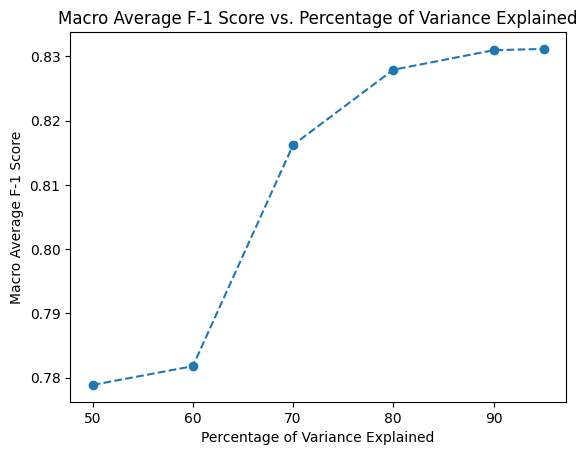

In [19]:
# plot each graph the macro average F-1 score for classification
import matplotlib.pyplot as plt

plt.plot([50, 60, 70, 80, 90, 95], avg_f1, '--o')
plt.title('Macro Average F-1 Score vs. Percentage of Variance Explained')
plt.ylabel('Macro Average F-1 Score')
plt.xlabel('Percentage of Variance Explained')
plt.show()



### 2. [1.5 hours.] Follow the instructions in this article: [medium](https://medium.com/0xcode/content-based-filtering-in-recommendation-system-using-jupyter-colab-notebook-9d3e0520af8)

In [20]:
import pandas as pd
df = pd.read_csv('movies.csv',sep=',', encoding='latin-1')


In [21]:
df.sample(5)

movieId                       title                 genres
1245     1655             Phantoms (1998)  Drama|Horror|Thriller
3136     4220    Longest Yard, The (1974)                 Comedy
1924     2552  My Boyfriend's Back (1993)                 Comedy
2997     4012            Punchline (1988)           Comedy|Drama
5188     8427          Americathon (1979)          Comedy|Sci-Fi

In [22]:
# split the genres
df['genres'] = df['genres'].str.split('|').astype(str)
df.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                              genres  
0  ['Adventure', 'Animation', 'Children', 'Comedy...  
1               ['Adventure', 'Children', 'Fantasy']  
2                              ['Comedy', 'Romance']  
3                     ['Comedy', 'Drama', 'Romance']  
4                                         ['Comedy']

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


##### 2.1 [20 points.] To perform content based filtering on the movies.csv dataset that can be found under “Lecture 8” of this course’s shared Google Drive folder. You should be able to query the movie “Dark Knight” like in the article.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer


tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df['genres'])
tfidf_matrix.shape

(9742, 177)

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.31379419, 0.0611029 , 0.05271111],
       [0.31379419, 1.        , 0.        , 0.        ],
       [0.0611029 , 0.        , 1.        , 0.35172407],
       [0.05271111, 0.        , 0.35172407, 1.        ]])

In [26]:
titles = df['title']
indices = pd.Series(df.index, index=df['title'])

In [27]:
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [28]:
genre_recommendations('Dark Knight, The (2008)').head(20)

8387                          Need for Speed (2014)
8149      Grandmaster, The (Yi dai zong shi) (2013)
123                                Apollo 13 (1995)
8026                              Life of Pi (2012)
8396                                    Noah (2014)
38                           Dead Presidents (1995)
341                              Bad Company (1995)
347             Faster Pussycat! Kill! Kill! (1965)
430                        Menace II Society (1993)
568                          Substitute, The (1996)
665                          Nothing to Lose (1994)
1645                       Untouchables, The (1987)
1696                           Monument Ave. (1998)
2563                              Death Wish (1974)
2574                        Band of the Hand (1986)
3037                              Foxy Brown (1974)
3124    Harley Davidson and the Marlboro Man (1991)
3167                                Scarface (1983)
3217                               Swordfish (2001)
3301        

##### 2.2 [10 points.] For each user query also output the Genres of the movie you are querying. For each output in addition to the movie ID and movie name of the similar movies, please also show the genres and the similarity score of each. Show your results for these 2 movies: “Ghost (1990)” and “Terminator, The (1984)”.

In [29]:
def queryMovies(name):
    idx = indices[name]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]

    # get genres
    genres = df.iloc[movie_indices, 2]

    # get MovieId
    movieId = df.iloc[movie_indices, 0]

    # get titles
    titles = df.iloc[movie_indices, 1]

    #get similarity scores
    scores = []
    for i in sim_scores:
        scores.append(i[1])

    # create dataframe
    recommendation_data = pd.DataFrame(columns=['MovieId', 'Title', 'Genres', 'SimilarityScore'])
    recommendation_data['Genres'] = genres
    recommendation_data['MovieId'] = movieId
    recommendation_data['Title'] = titles
    recommendation_data['SimilarityScore'] = scores

    return recommendation_data

In [30]:
# get recommendations
queryMovies('Ghost (1990)')

MovieId                                              Title  \
6905    63992                                    Twilight (2008)   
1085     1409                                     Michael (1996)   
1530     2065                   Purple Rose of Cairo, The (1985)   
2103     2797                                         Big (1988)   
2350     3108                            Fisher King, The (1991)   
2510     3358                         Defending Your Life (1991)   
3097     4157                          Price of Milk, The (2000)   
3249     4392                                       Alice (1990)   
4356     6373                              Bruce Almighty (2003)   
4744     7067  Juliet of the Spirits (Giulietta degli spiriti...   
5142     8254                               Arizona Dream (1993)   
5352     8919                                        P.S. (2004)   
6256    46976                       Stranger than Fiction (2006)   
6282    47725                                     Angel-A (2005)   
6299    48082  Science of Sleep, The (La science des rÃªves) ...   
7361    78703                                       TiMER (2009)   
9047   141818                            Ordinary Miracle (1978)   
228       265  Like Water for Chocolate (Como agua para choco...   
441       506                                     Orlando (1992)   
723       943                    Ghost and Mrs. Muir, The (1947)   

                                           Genres  SimilarityScore  
6905  ['Drama', 'Fantasy', 'Romance', 'Thriller']         0.940520  
1085    ['Comedy', 'Drama', 'Fantasy', 'Romance']         0.844785  
1530    ['Comedy', 'Drama', 'Fantasy', 'Romance']         0.844785  
2103    ['Comedy', 'Drama', 'Fantasy', 'Romance']         0.844785  
2350    ['Comedy', 'Drama', 'Fantasy', 'Romance']         0.844785  
2510    ['Comedy', 'Drama', 'Fantasy', 'Romance']         0.844785  
3097    ['Comedy', 'Drama', 'Fantasy', 'Romance']         0.844785  
3249    ['Comedy', 'Drama', 'Fantasy', 'Romance']         0.844785  
4356    ['Comedy', 'Drama', 'Fantasy', 'Romance']         0.844785  
4744    ['Comedy', 'Drama', 'Fantasy', 'Romance']         0.844785  
5142    ['Comedy', 'Drama', 'Fantasy', 'Romance']         0.844785  
5352    ['Comedy', 'Drama', 'Fantasy', 'Romance']         0.844785  
6256    ['Comedy', 'Drama', 'Fantasy', 'Romance']         0.844785  
6282    ['Comedy', 'Drama', 'Fantasy', 'Romance']         0.844785  
6299    ['Comedy', 'Drama', 'Fantasy', 'Romance']         0.844785  
7361    ['Comedy', 'Drama', 'Fantasy', 'Romance']         0.844785  
9047    ['Comedy', 'Drama', 'Fantasy', 'Romance']         0.844785  
228               ['Drama', 'Fantasy', 'Romance']         0.773460  
441               ['Drama', 'Fantasy', 'Romance']         0.773460  
723               ['Drama', 'Fantasy', 'Romance']         0.773460

In [31]:
queryMovies('Terminator, The (1984)')

MovieId                   Title                            Genres  \
68         76        Screamers (1995)  ['Action', 'Sci-Fi', 'Thriller']   
144       172  Johnny Mnemonic (1995)  ['Action', 'Sci-Fi', 'Thriller']   
296       338       Virtuosity (1995)  ['Action', 'Sci-Fi', 'Thriller']   
336       379          Timecop (1994)  ['Action', 'Sci-Fi', 'Thriller']   
474       541     Blade Runner (1982)  ['Action', 'Sci-Fi', 'Thriller']   
567       692             Solo (1996)  ['Action', 'Sci-Fi', 'Thriller']   
601       748     Arrival, The (1996)  ['Action', 'Sci-Fi', 'Thriller']   
939      1240  Terminator, The (1984)  ['Action', 'Sci-Fi', 'Thriller']   
1373     1882         Godzilla (1998)  ['Action', 'Sci-Fi', 'Thriller']   
1939     2571      Matrix, The (1999)  ['Action', 'Sci-Fi', 'Thriller']   
1961     2600         eXistenZ (1999)  ['Action', 'Sci-Fi', 'Thriller']   
2636     3527         Predator (1987)  ['Action', 'Sci-Fi', 'Thriller']   
2759     3697       Predator 2 (1990)  ['Action', 'Sci-Fi', 'Thriller']   
2970     3981       Red Planet (2000)  ['Action', 'Sci-Fi', 'Thriller']   
2974     3986     6th Day, The (2000)  ['Action', 'Sci-Fi', 'Thriller']   
3283     4443          Outland (1981)  ['Action', 'Sci-Fi', 'Thriller']   
3355     4553        They Live (1988)  ['Action', 'Sci-Fi', 'Thriller']   
3569     4887         One, The (2001)  ['Action', 'Sci-Fi', 'Thriller']   
3734     5181        Hangar 18 (1980)  ['Action', 'Sci-Fi', 'Thriller']   
4118     5903      Equilibrium (2002)  ['Action', 'Sci-Fi', 'Thriller']   

      SimilarityScore  
68                1.0  
144               1.0  
296               1.0  
336               1.0  
474               1.0  
567               1.0  
601               1.0  
939               1.0  
1373              1.0  
1939              1.0  
1961              1.0  
2636              1.0  
2759              1.0  
2970              1.0  
2974              1.0  
3283              1.0  
3355              1.0  
3569              1.0  
3734              1.0  
4118              1.0

### 3. [30 points. 2 hours.] Modify the “CNN 10 Classes” program shown in class to make it classify the 7 people’s faces used in the “Eigenfaces” program. Here you should not reduce the number of dimensions, but use the original image before PCA. You can look into this [site](https://duchesnay.github.io/pystatsml/auto_gallery/ml_lab_face_recognition.html) under “Basic ConvNet” to help you decide what architecture to choose for your CNN. Report your precision and macro average F-1 score

##### import dataset

In [32]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names

n_classes = target_names.shape[0]

print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

n_samples: 1288
n_features: 1850
n_classes: 7


##### function

In [33]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Plot a gallery of portraits."""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(min(images.shape[0], n_row * n_col)):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    """Plot the result of the prediction on a portion of the test set."""
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)


def label_proportion(x, decimals=2):
    """Labels's proportions."""
    unique, counts = np.unique(x, return_counts=True)
    return dict(zip(unique, np.round(counts / len(x), decimals)))

##### split dataset into training and testing sets

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

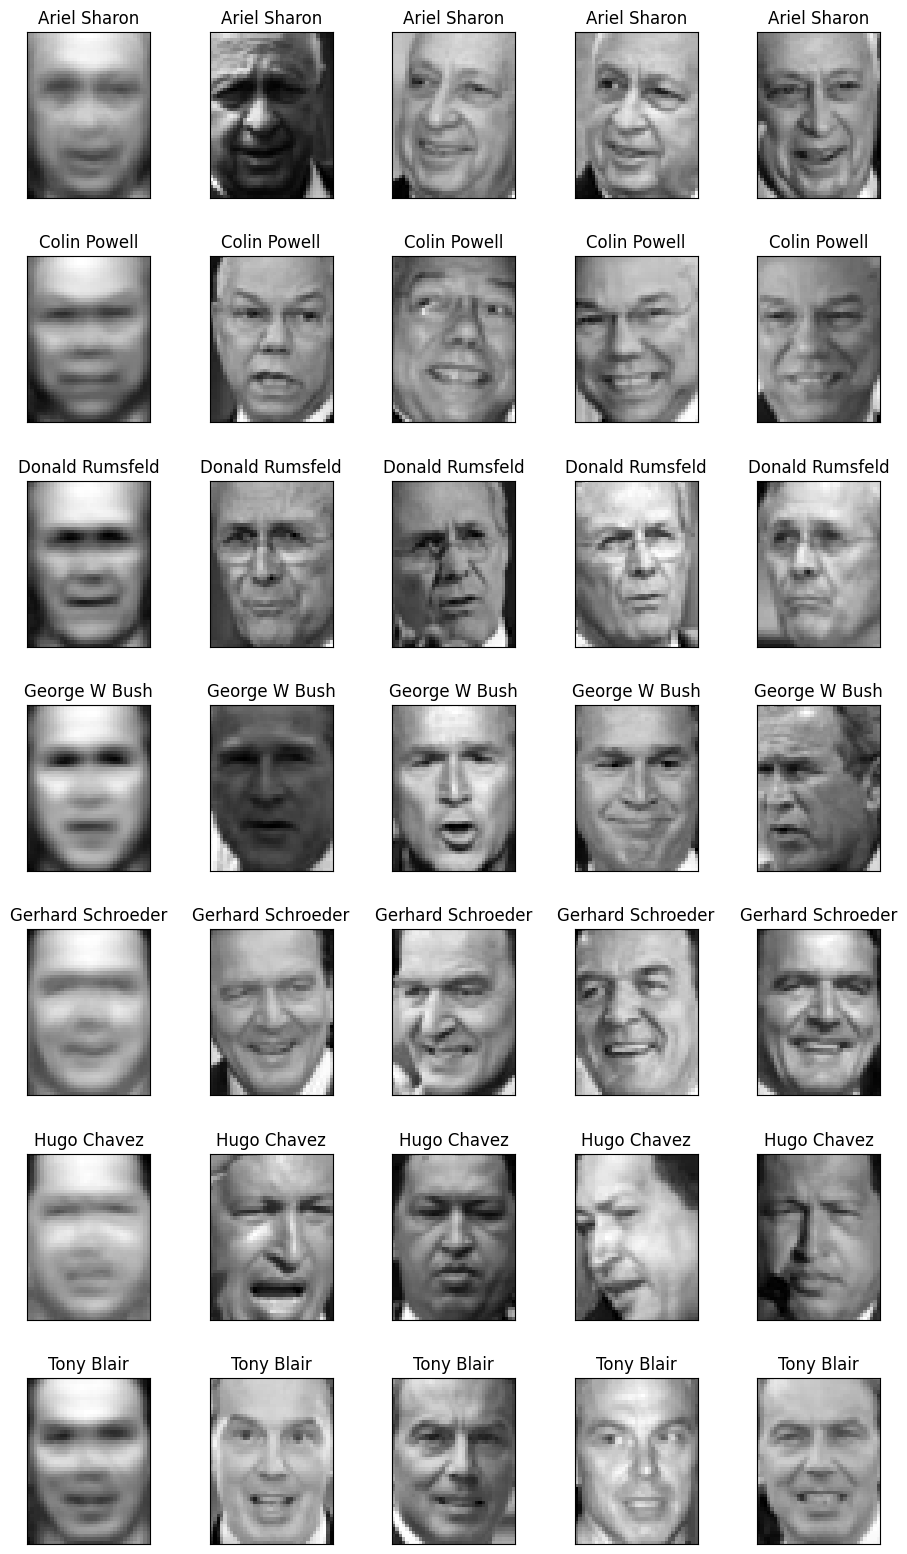

In [35]:
single_faces = [X_train[y_train == lab][:5] for lab in np.unique(y_train)]
single_faces = np.vstack(single_faces).reshape((5 * n_classes, h, w))

mean_faces = [X_train[y_train == lab].mean(axis=0) for lab in
              np.unique(y_train)]
mean_faces = np.vstack(mean_faces).reshape((n_classes, h, w))

single_faces[::5, :, :] = mean_faces
titles = [n for name in target_names for n in [name] * 5]
plot_gallery(single_faces, titles, h, w, n_row=n_classes, n_col=5)

##### CNN

In [36]:
# Pytorch Models
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier
import skorch
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
class Cnn(nn.Module):
    """Basic ConvNet Conv(1, 32, 64) -> FC(100, 7) -> softmax."""

    def __init__(self, dropout=0.5, fc_size=4928, n_outputs=7, debug=False):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(fc_size, 100)
        self.fc2 = nn.Linear(100, n_outputs)
        self.fc1_drop = nn.Dropout(p=dropout)
        self.debug = debug

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        if self.debug:  # trick to get the size of the first FC
            print("### DEBUG: Shape of last convnet=", x.shape,
                  ". FC size=", np.prod(x.shape[1:]))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [38]:
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

torch.manual_seed(0)
cnn = NeuralNetClassifier(
        Cnn,
        max_epochs=100,
        lr=0.001,
        optimizer=torch.optim.Adam,
        device=device,
        iterator_train__shuffle=True,
        callbacks=[skorch.callbacks.EpochScoring('accuracy'),
                         skorch.callbacks.EarlyStopping(patience=5)]
        )

scaler = preprocessing.MinMaxScaler()
X_train_s = scaler.fit_transform(X_train).reshape(-1, 1, h, w)
X_test_s = scaler.transform(X_test).reshape(-1, 1, h, w)

t0 = time()
cnn.fit(X_train_s, y_train)
print("done in %0.3fs" % (time() - t0))

y_pred = cnn.predict(X_test_s)
print(classification_report(y_test, y_pred, target_names=target_names))


  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3969        1.8234       0.3969        1.7096  0.9075
      2      0.3969        1.7707       0.3969        1.7115  1.0488
      3      0.3969        1.7524       0.3969        1.6971  1.3178
      4      0.3969        1.7346       0.3969        1.6885  1.0178
      5      0.3969        1.7248       0.3969        1.6864  1.2531
      6      0.3969        1.7130       0.3969        1.6507  1.2015
      7      0.3969        1.6911       0.3969        1.6191  1.0885
      8      0.4072        1.6768       0.4072        1.6003  1.1273
      9      0.4175        1.6402       0.4175        1.5625  1.1126
     10      0.4124        1.5984       0.4124        1.5308  1.1066
     11      0.4330        1.5798       0.4330        1.4925  1.1069
     12      0.4536        1.5784       0.4536        1.4498  0.9946
     13      0.4691        1.5354 

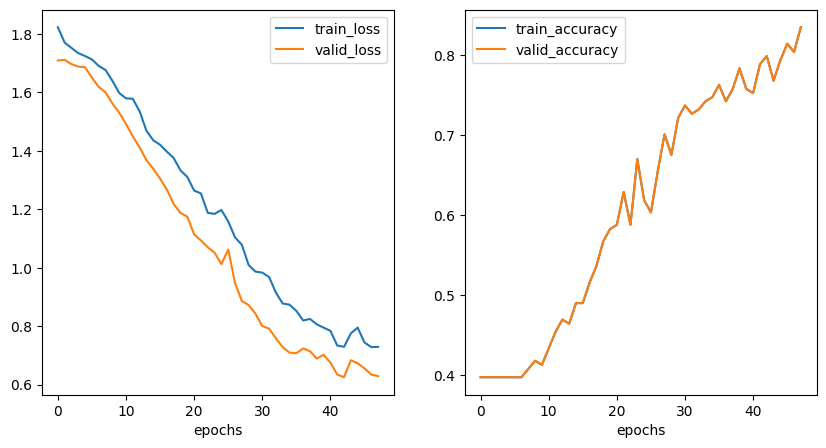

In [39]:
# plot your precision and macro average F-1 score
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn.history[:, 'train_loss'], label='train_loss')
plt.plot(cnn.history[:, 'valid_loss'], label='valid_loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn.history[:, 'accuracy'], label='train_accuracy')
plt.plot(cnn.history[:, 'valid_acc'], label='valid_accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

### 4. [10 points. 0.5 hours.] Try your own image on the “Haar Cascade Classifier.ipynb” shown in class to detect faces.

In [40]:
# these imports let you use opencv
import cv2 as cv#opencv itself
import common #some useful opencv functions
import numpy as np # matrix manipulations

#the following are to do with this interactive notebook code
%matplotlib inline 
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook

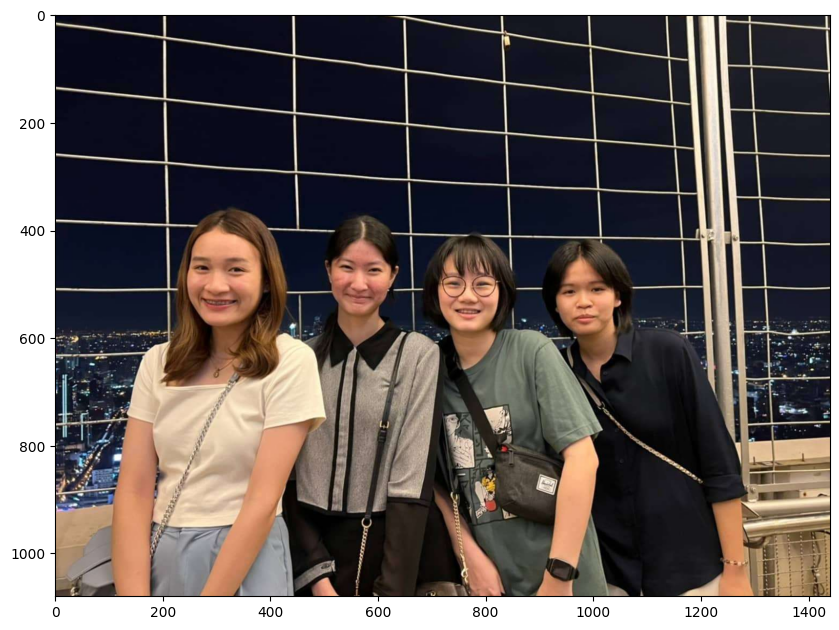

In [41]:
TFBOYS_image = cv.imread('test.jpg')
grey = cv.cvtColor(TFBOYS_image, cv.COLOR_BGR2GRAY)
plt.imshow(cv.cvtColor(TFBOYS_image, cv.COLOR_BGR2RGB))

##### Face Detection

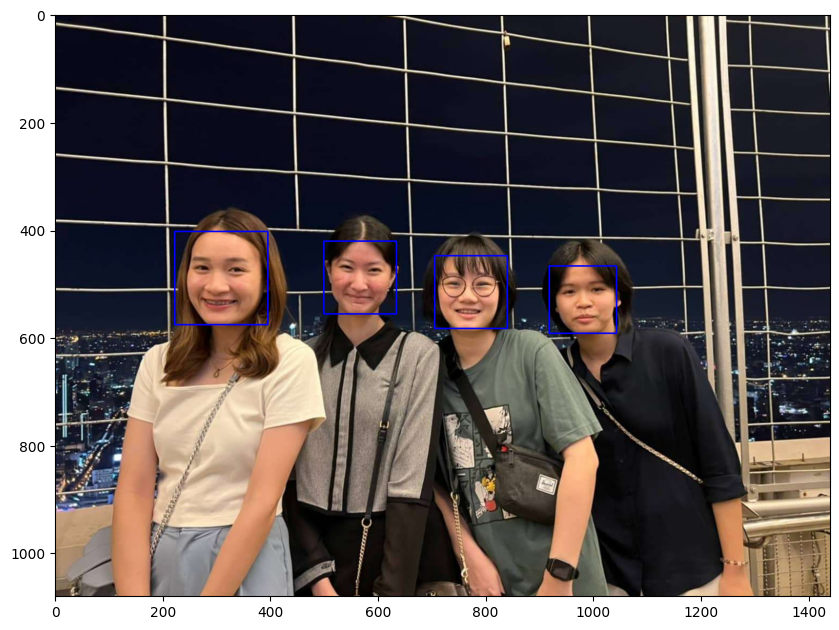

In [42]:
test_image = cv.imread('test.jpg')
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(test_image, 1.3, 5)
for (x,y,w,h) in faces:
    cv.rectangle(test_image,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(cv.cvtColor(test_image, cv.COLOR_BGR2RGB))


##### Smile Detection

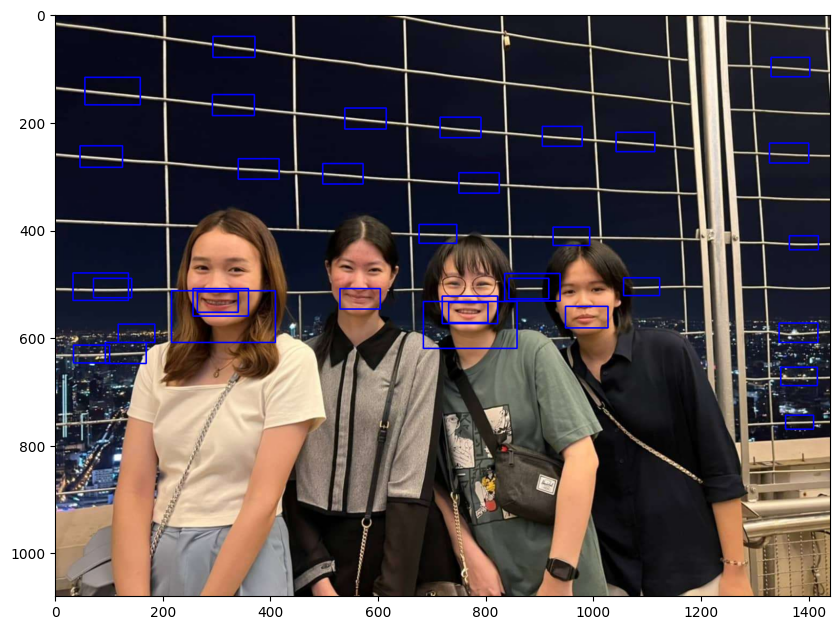

In [43]:
test_image = cv.imread('test.jpg')
smile_cascade = cv.CascadeClassifier('haarcascade_smile.xml')
smiles = smile_cascade.detectMultiScale(grey, 1.3, 20)
for (x,y,w,h) in smiles:
    cv.rectangle(test_image,(x,y),(x+w,y+h),(255,0,0),2)

plt.imshow(cv.cvtColor(test_image, cv.COLOR_BGR2RGB))


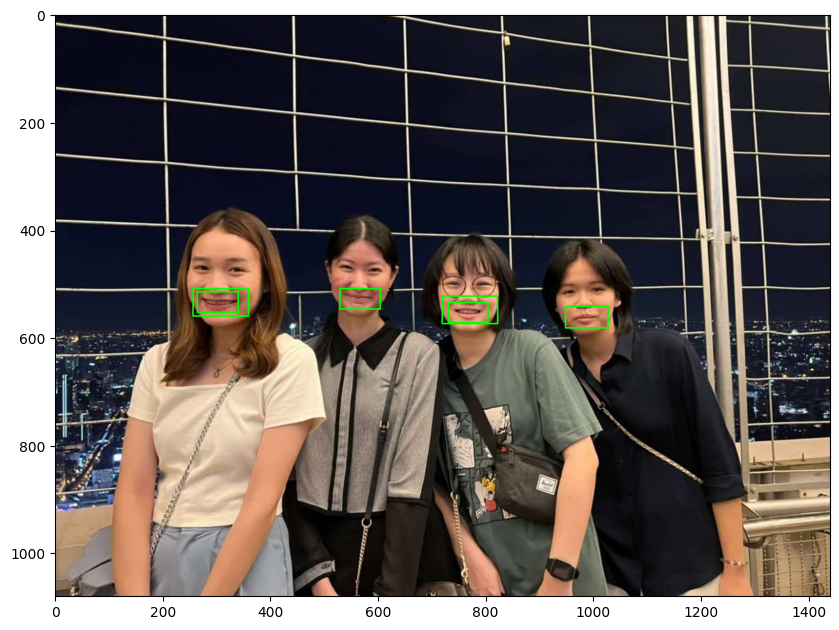

In [44]:
test_image = cv.imread('test.jpg')
for (x,y,w,h) in faces:
    for(x_s,y_s,w_s,h_s) in smiles:
        if(x_s>x and y_s>y and x_s+w_s<x+w and y_s+h_s<y+h):
             cv.rectangle(test_image, (x_s,y_s),(x_s+w_s,y_s+h_s),(0,255,0),2)
plt.imshow(cv.cvtColor(test_image, cv.COLOR_BGR2RGB))

##### Eye Detection

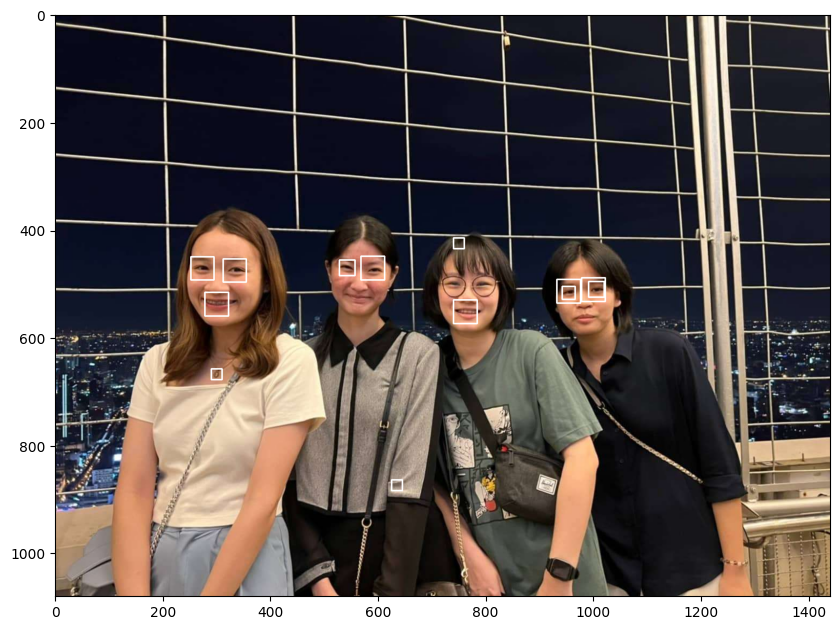

In [45]:
test_image = cv.imread('test.jpg')
eye_cascade = cv.CascadeClassifier('haarcascade_eye.xml')
eyes = eye_cascade.detectMultiScale(grey, 1.3, 1)
for (x,y,w,h) in eyes:
     cv.rectangle(test_image,(x,y),(x+w,y+h),(255,255,255),2)
plt.imshow(cv.cvtColor(test_image, cv.COLOR_BGR2RGB))


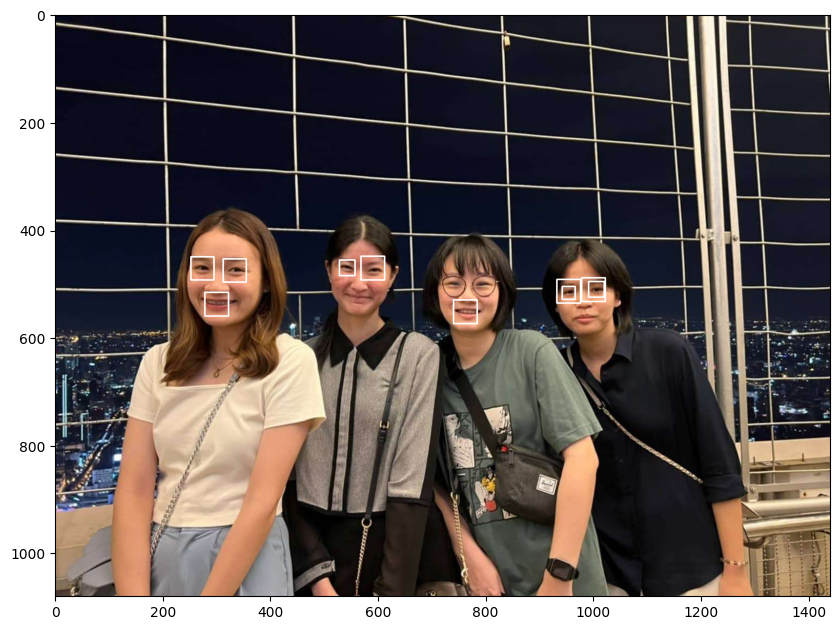

In [46]:
test_image = cv.imread('test.jpg')
for (x,y,w,h) in faces:
  #cv2.rectangle(smile_faces_base_image,(x,y),(x+w,y+h),(255,0,0),2)
  for (x_s,y_s,w_s,h_s) in eyes:
    if( (x <= x_s) and (y <= y_s) and ( x+w >= x_s+w_s) and ( y+h >= y_s+h_s)):
      cv.rectangle(test_image, (x_s,y_s),(x_s+w_s,y_s+h_s),(255,255,255),2)
plt.imshow(cv.cvtColor(test_image, cv.COLOR_BGR2RGB))

##### Putting all together

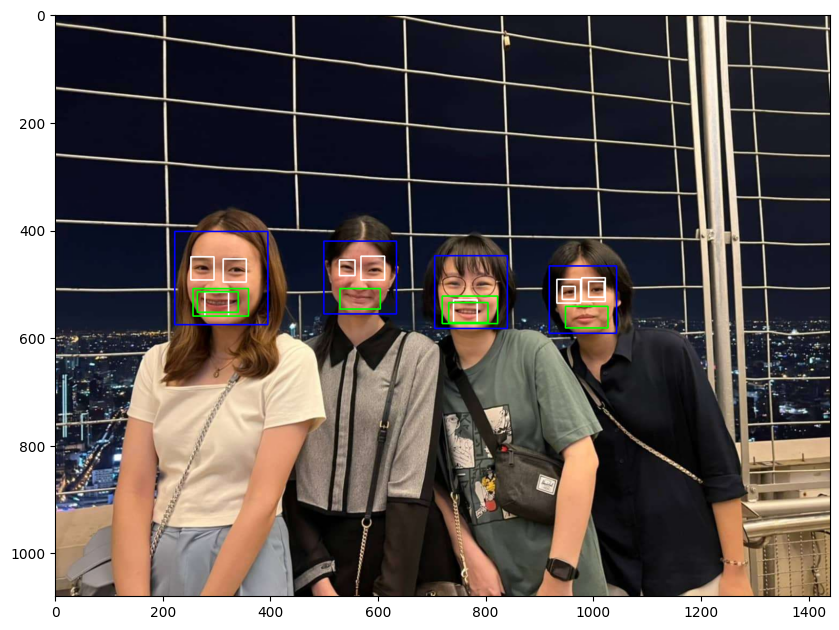

In [47]:
test_image = cv.imread('test.jpg')
for (x,y,w,h) in faces:
  cv.rectangle(test_image,(x,y),(x+w,y+h),(255,0,0),2)
  for (x_s,y_s,w_s,h_s) in eyes:
    if( (x <= x_s) and (y <= y_s) and ( x+w >= x_s+w_s) and ( y+h >= y_s+h_s)):
      cv.rectangle(test_image, (x_s,y_s),(x_s+w_s,y_s+h_s),(255,255,255),2)
  for (x_s,y_s,w_s,h_s) in smiles:
    if( (x <= x_s) and (y <= y_s) and ( x+w >= x_s+w_s) and ( y+h >= y_s+h_s)):
      cv.rectangle(test_image, (x_s,y_s),(x_s+w_s,y_s+h_s),(0,255,0),2)
plt.imshow(cv.cvtColor(test_image, cv.COLOR_BGR2RGB))